Objective: Create a machine learning model that predicts customer behavior on an e-commerce platform using real-time data streams to improve conversion rates and enhance customer experience.

In [1]:
#Libraries
import pandas as pd
from pathlib import Path
import dask.dataframe as dd #too large for pandas to read so using dask

from collections import defaultdict
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

import heapq
from datetime import timedelta
import joblib

Load Data and Data Processing

In [2]:
df = dd.read_csv('2019-Nov.csv')
df.head(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [3]:
df.shape #only gave number of columns

(Delayed('int-864eb7f9-2a93-4b64-ae39-1a89a9642286'), 9)

In [4]:
num_rows = df['event_type'].count().compute()
num_rows

67501979

In [5]:
def load_day_from_csv(csv_path: str, target_date: str, chunksize: int = 100_000) -> pd.DataFrame:
    """
    Efficiently load only the rows from `csv_path` where event_time matches `target_date` (YYYY-MM-DD).
    Stops early if data is sorted and target date is passed.
    """
    chunks = []
    for chunk in pd.read_csv(csv_path, chunksize=chunksize, parse_dates=['event_time'], date_parser=pd.to_datetime):
        chunk['event_date'] = chunk['event_time'].dt.strftime('%Y-%m-%d')
        
        # If the latest date in this chunk is earlier than target, keep going
        if chunk['event_date'].max() < target_date:
            continue
        
        # If the earliest date in this chunk is after target, stop
        if chunk['event_date'].min() > target_date:
            break
        
        # Otherwise, extract matching rows
        filtered = chunk[chunk['event_date'] == target_date]
        if not filtered.empty:
            chunks.append(filtered.drop(columns='event_date'))

    return pd.concat(chunks, ignore_index=True) if chunks else pd.DataFrame()

In [6]:
def shard_dataframe_by_user_suffix(df: pd.DataFrame, output_dir: str):
    """
    Splits the DataFrame by user_id % 100 (remainder of division) and appends each group to {output_dir}/XX.csv
    """
    if df.empty:
        return
    
    df['suffix'] = df['user_id'] % 100
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for suffix, group in df.groupby('suffix'):
        out_path = output_dir / f"{suffix:02d}.csv"
        group.drop(columns='suffix').to_csv(out_path, mode='a', index=False, header=not out_path.exists())


In [7]:
file = '2019-Nov.csv'
day = "2019-11-01"
df_day = load_day_from_csv(file, day)
shard_dataframe_by_user_suffix(df_day, "sharded_by_suffix")

C:\Users\emmal\AppData\Local\Temp\ipykernel_21816\3097906396.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  for chunk in pd.read_csv(csv_path, chunksize=chunksize, parse_dates=['event_time'], date_parser=pd.to_datetime):


How many unique customers in each chunk for Day 1?

In [8]:
def count_unique_user_ids_per_csv(input_dir: str) -> dict:
    """
    For each CSV file in `input_dir`, count the number of unique user_ids.
    Returns a dictionary: {'00.csv': count, '01.csv': count, ...}
    """
    input_path = Path(input_dir)
    result = {}

    for file in sorted(input_path.glob("*.csv")):
        try:
            df = pd.read_csv(file, usecols=['user_id'])
            unique_count = df['user_id'].nunique()
            result[file.name] = unique_count
        except Exception as e:
            print(f"Error processing {file.name}: {e}")
    
    return result

In [9]:
counts = count_unique_user_ids_per_csv("sharded_by_suffix")
for filename, count in counts.items():
    print(f"{filename}: {count} unique users")

00.csv: 2219 unique users
01.csv: 2161 unique users
02.csv: 2220 unique users
03.csv: 2190 unique users
04.csv: 2122 unique users
05.csv: 2288 unique users
06.csv: 2218 unique users
07.csv: 2263 unique users
08.csv: 2179 unique users
09.csv: 2183 unique users
10.csv: 2279 unique users
11.csv: 2269 unique users
12.csv: 2183 unique users
13.csv: 2310 unique users
14.csv: 2222 unique users
15.csv: 2249 unique users
16.csv: 2170 unique users
17.csv: 2165 unique users
18.csv: 2243 unique users
19.csv: 2227 unique users
20.csv: 2333 unique users
21.csv: 2265 unique users
22.csv: 2317 unique users
23.csv: 2251 unique users
24.csv: 2169 unique users
25.csv: 2209 unique users
26.csv: 2380 unique users
27.csv: 2226 unique users
28.csv: 2295 unique users
29.csv: 2230 unique users
30.csv: 2135 unique users
31.csv: 2318 unique users
32.csv: 2175 unique users
33.csv: 2169 unique users
34.csv: 2247 unique users
35.csv: 2281 unique users
36.csv: 2310 unique users
37.csv: 2224 unique users
38.csv: 2262

How many unique users Day 1?

In [10]:
# This is faster, but if there was a duplicate in sepearte files, for example 01 is in file 1 and file 2, it will overcount. I did not think this would be an issue since it is separated based on unique user ids.

total_estimated = sum(counts.values())
print(f"Total unique user_ids: {total_estimated}")

Total unique user_ids: 223108


In [11]:
#There is this way to make sure, as you can see, we got the same output, but it does take longer since it goes through each chunk/file

def count_total_unique_users(input_dir: str) -> int:
    """
    Collects all user_ids from all CSVs in `input_dir` and returns the total unique count.
    """
    input_path = Path(input_dir)
    unique_users = set()

    for file in input_path.glob("*.csv"):
        try:
            df = pd.read_csv(file, usecols=['user_id'])
            unique_users.update(df['user_id'].unique())
        except Exception as e:
            print(f"Error processing {file.name}: {e}")

    return len(unique_users)

In [12]:
total_unique = count_total_unique_users("sharded_by_suffix")
print(f"Total unique user_ids: {total_unique}")

Total unique user_ids: 223108


How much did each customer spend on avg Day 1?

In [13]:
def compute_average_spend_per_user(input_dir: str) -> pd.DataFrame:
    """
    Computes average spending per user from all CSVs in `input_dir`.
    Returns a DataFrame sorted by average spend (descending).
    """
    input_path = Path(input_dir)
    total_spend = defaultdict(float)
    count = defaultdict(int)
    for file in input_path.glob("*.csv"):
        try:
            df = pd.read_csv(file, usecols=['user_id', 'price', 'event_type'])
            df = df[df['event_type'] == 'purchase']
            grouped = df.groupby('user_id')['price'].agg(['sum', 'count'])
            for user_id, row in grouped.iterrows():
                total_spend[user_id] += row['sum']
                count[user_id] += row['count']
        except Exception as e:
            print(f"Error processing {file.name}: {e}")

    # Create final DataFrame
    data = {
        'user_id': [],
        'average_spend': []
    }
    for user_id in total_spend:
        data['user_id'].append(user_id)
        data['average_spend'].append(total_spend[user_id] / count[user_id])

    df_result = pd.DataFrame(data)
    df_result.sort_values(by='average_spend', ascending=False, inplace=True)
    return df_result


In [14]:
avg_spend_df = compute_average_spend_per_user("sharded_by_suffix")
print(avg_spend_df.head(10))  # Top 10 spenders

         user_id  average_spend
3540   556418321        2574.04
8587   561277952        2570.18
5368   515819233        2496.59
6389   547043839        2393.63
14599  566411788        2393.63
4990   562137230        2393.63
2877   512375018        2180.21
11364  524555769        2136.22
13374  516690881        2064.02
7137   512905944        2059.00


In [15]:
avg_spend_df.tail(15)

,user_id,average_spend
3782,513457523,3.71
2209,565985013,3.67
4488,562313427,3.58
1371,542178308,3.54
15633,525944695,3.35
7355,519095145,2.97
11521,518518970,2.93
15927,518260597,2.93
16358,565852799,2.72
11566,540372270,2.57


The top 3 categories for the top 10 spenders

In [16]:
def top_3_categories_per_top_users(input_dir: str, top_users: list) -> dict:
    """
    For each user in `top_users`, find their top 3 most frequent category_code values.
    Returns: {user_id: [(category_code, count), ...], ...}
    """
    input_path = Path(input_dir)
    user_categories = {uid: Counter() for uid in top_users}

    for file in input_path.glob("*.csv"):
        try:
            df = pd.read_csv(file, usecols=['user_id', 'category_code'])
            df = df[df['user_id'].isin(top_users)]
            for uid, group in df.groupby('user_id'):
                user_categories[uid].update(group['category_code'].dropna())
        except Exception as e:
            print(f"Error processing {file.name}: {e}")
    
    # Extract top 3 per user
    top_3_per_user = {
        uid: user_categories[uid].most_common(3)
        for uid in top_users
    }
    return top_3_per_user

In [17]:
#It seems there is only one think they were looking at

top_spenders = avg_spend_df.head(15)['user_id'].tolist()
top_categories = top_3_categories_per_top_users("sharded_by_suffix", top_spenders)

for uid, categories in top_categories.items():
    print(f"\nUser {uid} - Top Categories:")
    for cat, count in categories:
        print(f"  {cat} ({count} times)")


User 556418321 - Top Categories:
  computers.notebook (28 times)

User 561277952 - Top Categories:
  computers.notebook (20 times)
  electronics.smartphone (4 times)
  electronics.audio.acoustic (4 times)

User 515819233 - Top Categories:
  computers.notebook (8 times)

User 547043839 - Top Categories:
  computers.desktop (16 times)

User 566411788 - Top Categories:
  computers.desktop (24 times)

User 562137230 - Top Categories:
  computers.desktop (24 times)

User 512375018 - Top Categories:

User 524555769 - Top Categories:
  electronics.video.tv (12 times)

User 516690881 - Top Categories:
  computers.desktop (8 times)

User 512905944 - Top Categories:
  computers.notebook (16 times)

User 566407162 - Top Categories:
  electronics.smartphone (32 times)

User 513990971 - Top Categories:
  electronics.smartphone (16 times)

User 519150704 - Top Categories:
  electronics.smartphone (12 times)

User 519518547 - Top Categories:
  electronics.smartphone (12 times)

User 525535480 - Top 

In [18]:
#now it should be just what they purchased

def top_3_categories_per_top_users(input_dir: str, top_users: list) -> dict:
    """
    For each user in `top_users`, find their top 3 most frequent category_code values.
    Returns: {user_id: [(category_code, count), ...], ...}
    """
    input_path = Path(input_dir)
    user_categories = {uid: Counter() for uid in top_users}

    for file in input_path.glob("*.csv"):
        try:
            df = pd.read_csv(file, usecols=['user_id', 'category_code', 'event_type'])
            df = df[df['event_type'] == 'purchase']
            df = df[df['user_id'].isin(top_users)]
            for uid, group in df.groupby('user_id'):
                user_categories[uid].update(group['category_code'].dropna())
        except Exception as e:
            print(f"Error processing {file.name}: {e}")
    
    # Extract top 3 per user
    top_3_per_user = {
        uid: user_categories[uid].most_common(3)
        for uid in top_users
    }
    return top_3_per_user

In [19]:
top_spenders = avg_spend_df.head(15)['user_id'].tolist()
top_categories = top_3_categories_per_top_users("sharded_by_suffix", top_spenders)

for uid, categories in top_categories.items():
    print(f"\nUser {uid} - Top Categories:")
    for cat, count in categories:
        print(f"  {cat} ({count} times)")


User 556418321 - Top Categories:
  computers.notebook (4 times)

User 561277952 - Top Categories:
  computers.notebook (4 times)

User 515819233 - Top Categories:
  computers.notebook (4 times)

User 547043839 - Top Categories:
  computers.desktop (4 times)

User 566411788 - Top Categories:
  computers.desktop (12 times)

User 562137230 - Top Categories:
  computers.desktop (8 times)

User 512375018 - Top Categories:

User 524555769 - Top Categories:
  electronics.video.tv (4 times)

User 516690881 - Top Categories:
  computers.desktop (4 times)

User 512905944 - Top Categories:
  computers.notebook (4 times)

User 566407162 - Top Categories:
  electronics.smartphone (4 times)

User 513990971 - Top Categories:
  electronics.smartphone (4 times)

User 519150704 - Top Categories:
  electronics.smartphone (4 times)

User 519518547 - Top Categories:
  electronics.smartphone (4 times)

User 525535480 - Top Categories:
  electronics.smartphone (4 times)


In [20]:
list(df["event_type"].unique())

['view', 'cart', 'purchase']

What time are the top spenders most active day 1?

In [21]:
def hourly_purchase_distribution(input_dir: str, top_users: list) -> dict:
    """
    For each user in `top_users`, compute a histogram of purchase hours (0–23).
    Returns: {user_id: Counter({hour: count, ...}), ...}
    """
    input_path = Path(input_dir)
    user_activity = {uid: Counter() for uid in top_users}

    for file in input_path.glob("*.csv"):
        try:
            df = pd.read_csv(file, usecols=['user_id', 'event_type', 'event_time'])
            df = df[df['event_type'] == 'purchase']
            df = df[df['user_id'].isin(top_users)]
            df['event_time'] = pd.to_datetime(df['event_time'], utc=True, errors='coerce')
            df['hour'] = df['event_time'].dt.hour

            for uid, group in df.groupby('user_id'):
                user_activity[uid].update(group['hour'].dropna().astype(int))
        except Exception as e:
            print(f"Error processing {file.name}: {e}")

    return user_activity

In [22]:
hourly_activity = hourly_purchase_distribution("sharded_by_suffix", top_spenders)

for uid, hour_counts in hourly_activity.items():
    top_hour = hour_counts.most_common(1)[0]
    print(f"User {uid} - Most active at hour {top_hour[0]} ({top_hour[1]} purchases)")


User 556418321 - Most active at hour 8 (4 purchases)
User 561277952 - Most active at hour 17 (4 purchases)
User 515819233 - Most active at hour 14 (4 purchases)
User 547043839 - Most active at hour 9 (4 purchases)
User 566411788 - Most active at hour 10 (12 purchases)
User 562137230 - Most active at hour 8 (4 purchases)
User 512375018 - Most active at hour 6 (4 purchases)
User 524555769 - Most active at hour 8 (4 purchases)
User 516690881 - Most active at hour 8 (4 purchases)
User 512905944 - Most active at hour 5 (4 purchases)
User 566407162 - Most active at hour 10 (4 purchases)
User 513990971 - Most active at hour 3 (4 purchases)
User 519150704 - Most active at hour 11 (4 purchases)
User 519518547 - Most active at hour 5 (4 purchases)
User 525535480 - Most active at hour 13 (4 purchases)


In [23]:
def plot_user_hourly_activity(user_id, hour_counts):
    hours = list(range(24))
    counts = [hour_counts.get(h, 0) for h in hours]
    plt.bar(hours, counts)
    plt.title(f"Hourly Purchase Activity for User {user_id}")
    plt.xlabel("Hour of Day (UTC)")
    plt.ylabel("Number of Purchases")
    plt.xticks(hours)
    plt.grid(True)
    plt.show()

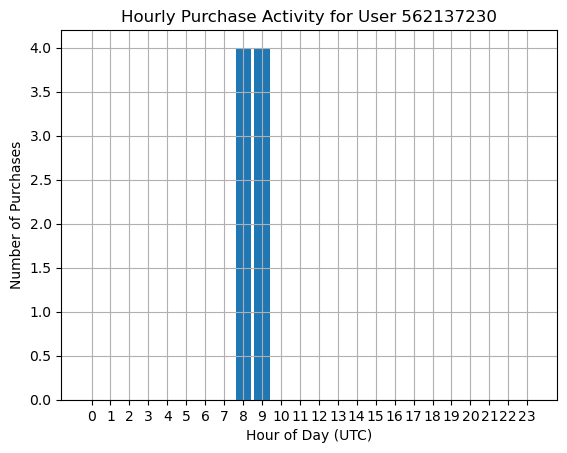

In [24]:
plot_user_hourly_activity(top_spenders[5], hourly_activity[top_spenders[5]])

What time are spenders most active Day 1?

In [25]:
def unique_users_per_purchase_hour(input_dir: str) -> pd.Series:
    """
    Computes number of unique users making purchases for each hour (0–23).
    Returns: pandas Series {hour: unique_user_count}
    """
    input_path = Path(input_dir)
    hour_user_set = defaultdict(set)

    for file in input_path.glob("*.csv"):
        try:
            df = pd.read_csv(file, usecols=['user_id', 'event_type', 'event_time'])
            df = df[df['event_type'] == 'purchase']
            df['event_time'] = pd.to_datetime(df['event_time'], utc=True, errors='coerce')
            df['hour'] = df['event_time'].dt.hour
            for hour, group in df.groupby('hour'):
                hour_user_set[hour].update(group['user_id'])
        except Exception as e:
            print(f"Error processing {file.name}: {e}")

    return pd.Series({hour: len(users) for hour, users in hour_user_set.items()}).sort_index()

In [26]:
def plot_unique_user_purchase_hours(series: pd.Series):
    plt.bar(series.index, series.values)
    plt.title("Unique Users Making Purchases by Hour (UTC)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Unique Users")
    plt.xticks(range(24))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

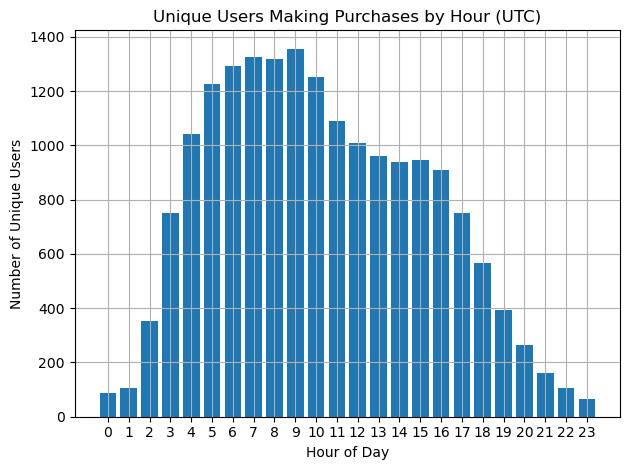

In [27]:
hourly_user_counts = unique_users_per_purchase_hour("sharded_by_suffix")
plot_unique_user_purchase_hours(hourly_user_counts)

Create dataset for Model

In [28]:
def create_labeled_session_dataset(input_dir: str) -> pd.DataFrame:
    """
    Generates a DataFrame where each row represents a user_session, with features and a label (1 if purchase occurred).
    """
    input_path = Path(input_dir)
    session_records = []

    for file in input_path.glob("*.csv"):
        try:
            df = pd.read_csv(file, usecols=[
                'user_id', 'user_session', 'event_time', 'event_type',
                'product_id', 'category_code', 'price'
            ])
            df['event_time'] = pd.to_datetime(df['event_time'], utc=True, errors='coerce')
            df.dropna(subset=['event_time', 'user_session'], inplace=True)

            for session_id, group in df.groupby('user_session'):
                group_sorted = group.sort_values('event_time')
                session_start = group_sorted['event_time'].min()
                session_end = group_sorted['event_time'].max()

                features = {
                    'user_session': session_id,
                    'user_id': group_sorted['user_id'].iloc[0],
                    'session_start': session_start,
                    'session_end': session_end,
                    'session_duration_sec': (session_end - session_start).total_seconds(),
                    'num_events': len(group),
                    'num_products_viewed': group['product_id'].nunique(),
                    'num_categories_viewed': group['category_code'].nunique(),
                    'avg_price_viewed': group['price'].mean(),
                    'hour_of_day': session_start.hour,
                    'has_purchase': int('purchase' in group['event_type'].values)
                }

                session_records.append(features)
        except Exception as e:
            print(f"Error processing {file.name}: {e}")

    return pd.DataFrame(session_records)

In [29]:
df_sessions = create_labeled_session_dataset("sharded_by_suffix")
df_sessions.to_csv("labeled_sessions.csv", index=False)  # Or .csv

In [30]:
df_sessions.head()

,user_session,user_id,session_start,session_end,session_duration_sec,num_events,num_products_viewed,num_categories_viewed,avg_price_viewed,hour_of_day,has_purchase
0,00168770-905d-4833-a68c-fdda54e2d166,513607400,2019-11-01 05:48:43+00:00,2019-11-01 05:51:01+00:00,138.0,8,2,2,58.29,5,0
1,0024cdd8-37be-4da4-bbfa-2a55d0145b78,566596800,2019-11-01 21:20:46+00:00,2019-11-01 21:23:44+00:00,178.0,8,1,1,242.13,21,0
2,0025c102-41fb-48a2-861a-9607595df34e,537586000,2019-11-01 08:55:30+00:00,2019-11-01 08:55:30+00:00,0.0,4,1,1,26.90,8,0
3,0041b48c-396f-4afe-91e5-66d575d8ca23,512470700,2019-11-01 07:17:45+00:00,2019-11-01 07:17:45+00:00,0.0,4,1,1,32.18,7,0
4,005e1bbc-1365-4bcd-a57e-d74e32839d2f,566604500,2019-11-01 22:08:59+00:00,2019-11-01 22:08:59+00:00,0.0,4,1,1,1342.40,22,0


Model to predict if user session results in a purchase

In [31]:
# Load the session-level dataset
df = pd.read_csv("labeled_sessions.csv")  # or .csv if saved as CSV

# Drop sessions with missing target label or extreme values
df = df.dropna(subset=['has_purchase'])

# Features and label
feature_cols = [
    'session_duration_sec',
    'num_events',
    'num_products_viewed',
    'num_categories_viewed',
    'avg_price_viewed',
    'hour_of_day'
]
X = df[feature_cols]
y = df['has_purchase']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
model = GradientBoostingClassifier()
model.fit(X_train_scaled, y_train)

GradientBoostingClassifier()

In [34]:
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC: 0.9245771353692971
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     60341
           1       0.60      0.21      0.31      3843

    accuracy                           0.94     64184
   macro avg       0.78      0.60      0.64     64184
weighted avg       0.93      0.94      0.93     64184



In [35]:
joblib.dump(model, "conversion_predictor.joblib")
joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']

In [36]:
# Load labeled session features
df = pd.read_csv("labeled_sessions.csv")

# Load model + scaler
model = joblib.load("conversion_predictor.joblib")
scaler = joblib.load("scaler.joblib")

# Define features used in training
feature_cols = [
    'session_duration_sec',
    'num_events',
    'num_products_viewed',
    'num_categories_viewed',
    'avg_price_viewed',
    'hour_of_day'
]

X = df[feature_cols]
X_scaled = scaler.transform(X)
probs = model.predict_proba(X_scaled)[:, 1]
preds = (probs >= 0.5).astype(int)

# Add predictions to DataFrame
df['predicted_prob'] = probs
df['predicted_label'] = preds

# Save for evaluation
df.to_csv("simulated_predictions.csv", index=False)